# Fairness

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

## Review

This is the third notebook in a series that explains the statistical arguments presented in two articles from 2016:

* "[Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)", by Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner, and published by [ProPublica](https://www.propublica.org) in May 2016.

* A response by Sam Corbett-Davies, Emma Pierson, Avi Feller and Sharad Goel: "[A computer program used for bail and sentencing decisions was labeled biased against blacks. It’s actually not that clear.](https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/)", published in the Washington Post.

I strongly encourage you to read both articles before you go on.

Both articles are about COMPAS, a statistical tool used in the justice system to assign defendants a "risk score" that is intended to reflect the risk that they will commit another crime if releases.

The ProPublica article evaluates COMPAS as a binary classifier, and compares its accuracy for black and white defendants.

In response, the Washington Post article also focuses on comparisons of black and white defendants.

In this notebook I replicate the analyses in both article, focusing on differences between male and female defendants.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

Thank you to ProPublica and the authors of "Machine Bias" for making their data and analysis freely available.

[Their repository](https://github.com/propublica/compas-analysis) contains the data and analysis pipeline described [this supplementary article](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.

The following cell downloads the data file we'll use directly from their repository.

In [3]:
import os

if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

The following cell reads the data file:

In [4]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

## Code

Here are some functions from previous notebooks that we will need again.

In [8]:
def make_matrix(cp, subgroup=slice(None), threshold=4):
    """Make a confusion matrix.
    
    cp: DataFrame
    subgroup: Boolean Series, default is all rows
    threshold: default is 4
    
    returns: DataFrame containing the confusion matrix
    """
    a = np.where(cp['decile_score'] > threshold, 
                 'Positive', 
                 'Negative')
    high_risk = pd.Series(a, name='Predicted')
    
    a = np.where(cp['two_year_recid'] == 1, 
                 'Condition', 
                 'No Condition')
    new_charge_2 = pd.Series(a, name='Actual')

    matrix = pd.crosstab(high_risk[subgroup], new_charge_2[subgroup])
    matrix.sort_index(axis=0, ascending=False, inplace=True)
    
    return matrix

In [9]:
def percent(x, y):
    """Compute the percentage `x/(x+y)*100`.
    """
    return x / (x+y) * 100

In [10]:
def predictive_value(m):
    """Compute positive and negative predictive value.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    ppv = percent(tp, fp)
    npv = percent(tn, fn)
    return ppv, npv

In [11]:
def sens_spec(m):
    """Compute sensitivity and specificity.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    sens = percent(tp, fn)
    spec = percent(tn, fp)
    return sens, spec

In [12]:
def error_rates(m):
    """Compute false positive and false negative rate.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    fpr = percent(fp, tn)
    fnr = percent(fn, tp)
    return fpr, fnr

In [13]:
def prevalence(df):
    """Compute prevalence.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = df.to_numpy().flatten()
    prevalence = percent(tp+fn, tn+fp)
    return prevalence

In [14]:
def compute_metrics(m, name=''):
    """Compute all metrics.
    
    m: confusion matrix
    
    returns: DataFrame
    """
    fpr, fnr = error_rates(m)
    ppv, npv = predictive_value(m)
    prev = prevalence(m)
    
    index = ['FP rate', 'FN rate', 'PPV', 'NPV', 'Prevalence']
    df = pd.DataFrame(index=index, columns=['Percent'])
    df.Percent = fpr, fnr, ppv, npv, prev
    df.index.name = name
    return df

In [15]:
def calibration_curve(df):
    """Compute probability of recidivism by decile score.
    
    df: DataFrame
    
    returns: Series
    """
    grouped = df.groupby('decile_score')
    return grouped['two_year_recid'].mean()

In [16]:
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

## Male and female defendants

In this dataset, about 81% of defendants are male.

In [17]:
male = (cp['sex'] == 'Male')
male.mean()

0.8066260049902967

In [18]:
female = (cp['sex'] == 'Female')
female.mean()

0.19337399500970334

Here are the confusion matrices for male and female defendants.

In [19]:
matrix_male = make_matrix(cp, male)
matrix_male

Actual,Condition,No Condition
Predicted,,
Positive,1732,994
Negative,1021,2072


In [20]:
matrix_female = make_matrix(cp, female)
matrix_female

Actual,Condition,No Condition
Predicted,,
Positive,303,288
Negative,195,609


And here are the metrics:

In [21]:
metrics_male = compute_metrics(matrix_male, 
                                'Male defendants')
metrics_male

,Percent
Male defendants,
FP rate,32.420091
FN rate,37.086814
PPV,63.536317
NPV,66.989977
Prevalence,47.310534


In [22]:
metrics_female = compute_metrics(matrix_female, 
                                'Female defendants')
metrics_female

,Percent
Female defendants,
FP rate,32.107023
FN rate,39.156627
PPV,51.269036
NPV,75.746269
Prevalence,35.698925


The fraction of defendants charged with another crime (prevalence) is substantially higher for male defendants (47% vs 36%).

Nevertheless, the error rates for the two groups are about the same.

As a result, the predictive values for the two groups are substantially different:

* PPV: Women classified as high risk are less likely to be charged with another crime, compared to high-risk men (51% vs 64%).

* NPV: Women classified as low risk are more likely to "survive" two years without a new charge, compared to low-risk men (76% vs 67%).

The difference in predictive values implies that COMPAS is not calibrated for men and women.  In the next section we'll campare the calibration curves.

## Calibration for male and female defendants

Here are the calibration curves for male and female defendants.

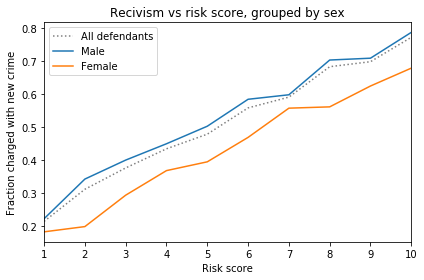

In [23]:
cal_all = calibration_curve(cp)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

cal_male = calibration_curve(cp[male])
cal_male.plot(label='Male')

cal_female = calibration_curve(cp[female])
cal_female.plot(label='Female')

decorate(xlabel='Risk score',
         ylabel='Fraction charged with new crime',
         title='Recivism vs risk score, grouped by sex')
plt.legend();

For all risk scores, female defendants are substantially less likely to be charged with another crime.

Or, reading the graph the other way, female defendants are given risk scores 1-2 points higher than male defendants with the same actual risk of recidivism.

To the degree that COMPAS scores are used to decide which defendants are incarcerated, those decisions:

* Are unfair to women.

* Are less effective than they could be, if they incarcerate lower-risk women while allowing higher-risk men to go free.

To understand these results, I will apply to these groups the same analyses we used in the previous notebook for black and white defendants.

## Constant predictive value model

If two groups have difference prevalence, a binary classifier can have the same predictive values (PPV and NPV) for both groups, or the same error rates (FPR and FNR), but not both at the same time.

* If we are given predictive values, we can compute error rates for any prevalence.  I call this is the constant predictive value (CPV) model.

* If we are given error rates, we can compute predictive values for any prevalence.  I call this the constant error rate (CER) model.

In the previous notebook, we saw that COMPAS does not follow either model with respect to black and white defendants.  Instead it seems to be "tempered", which means that when we compare groups with lower or higher prevalence:

* Error rates do not vary as much as the CPV model predicts.

* Predictive values do not vary as much as the CER model predicts.

The algorithms COMPAS uses are kept secret, so we can't tell whether this behavior is deliberate.

But we can get a clue by using the same analysis to compare other groups.

The following function takes `ppv`, `npv`, and `prev` and computes a confusion matrix with those metrics.

In [28]:
def constant_predictive_value(ppv, npv, prev):
    """Make a confusion matrix with given metrics.
    
    ppv: positive predictive value
    npv: negative predictive value
    prev: prevalence
    
    returns: confusion matrix
    """
    ppv /= 100
    npv /= 100
    prev /= 100
    a = np.array((ppv*(npv + prev - 1)/(npv + ppv - 1),
                -(ppv - 1)*(npv + prev - 1)/(npv + ppv - 1),
                -(npv - 1)*(ppv - prev)/(npv + ppv - 1),
                npv*(ppv - prev)/(npv + ppv - 1)))
    
    return pd.DataFrame(a.reshape((2, 2)))

First I'll compute predictive values for all defendants.

In [29]:
matrix_all = make_matrix(cp)

ppv, npv = predictive_value(matrix_all)
ppv, npv

(61.350618028338864, 68.79651013600206)

The I'll use the CPV model to predict error rates for a range of prevalences.

In [30]:
prevalences = np.linspace(35, 55, 11)

pred_er = pd.DataFrame(columns=['fpr', 'fnr'])

for prev in prevalences:
    m = constant_predictive_value(ppv, npv, prev)
    pred_er.loc[prev] = error_rates(m)
    
pred_er

,fpr,fnr
35.0,7.488034,77.925569
37.0,11.795671,68.118564
39.0,16.385776,59.317406
41.0,21.287075,51.374897
43.0,26.532324,44.171227
45.0,32.159046,37.607882
47.0,38.210427,31.603121
49.0,44.736425,26.088543
51.0,51.795158,21.006482
53.0,59.454634,16.307973


We'll compare the model with actual error rates for female and male defendants.

In [31]:
actual_er = pd.DataFrame(columns=['fpr', 'fnr'])

for m in (matrix_female, matrix_all, matrix_male):
    prev = prevalence(m)
    actual_er.loc[prev] = error_rates(m)
    
actual_er

,fpr,fnr
35.698925,32.107023,39.156627
45.065151,32.349230,37.403876
47.310534,32.420091,37.086814


The following figure compares predictions from the CPV model to actual error rates for female defendants (on the left), all defendants (in the middle), and male defendants (on the right).

In [32]:
def plot_cpv_model(pred_er):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_er['fpr'].plot(label='Predicted FPR', color='C2')
    pred_er['fnr'].plot(label='Predicted FNR', color='C4')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Error rates, constant predictive value')

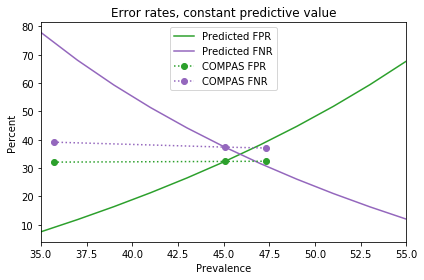

In [33]:
plot_cpv_model(pred_er)

actual_er['fpr'].plot(marker='o', linestyle='dotted', color='C2',
                      label='COMPAS FPR')

actual_er['fnr'].plot(marker='o', linestyle='dotted', color='C4',
                      label='COMPAS FNR')

plt.legend();

Although male and female defendants have very difference prevalences (rates of recidivism), their error rates are almost the same.

This is the "natural" behavior we should expect from a test that does not depend on sex.

If we look again at the definition of FPR and FNR, using this diagram from [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)

<img width=800, src='https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/confusion_matrix2.png'>

We see that FNR depends only on people in the positive condition (people who will recidivate) and FPR depends only on people in the negative condition (people who will "survive" without being charged with another crime).

Neither error rate depends on how many people are in each condition, so if the test is sex blind, it should have the same error rates for both sexes, regardless of prevalence.

## Constant error rate model

The previous section shows the COMPAS has the same error rates for male and female defendants, even though they have substantially difference prevalences.

So we expected the test to have different predictive values for these groups.  To confirm that I'll compute the actual predictive values and compare them to the CER model.

The following function takes prevalence and error rates and returns a confusion matrix.

In [34]:
def constant_error_rates(fpr, fnr, prev):
    """Make a confusion matrix with given metrics.
    
    fpr: false positive rate
    fnr: false negative rate
    prev: prevalence
    
    returns: confusion matrix
    """
    prev /= 100
    fpr /= 100
    fnr /= 100
    a = [[prev*(1 - fnr),  fpr*(1 - prev)],
         [fnr*prev,       (fpr - 1)*(prev - 1)]]
    
    return pd.DataFrame(a)

Again, I'll use the error rates for all defendants:

In [ ]:
fpr, fnr = error_rates(matrix_all)

The I'll use the CER model to compute PPV and NPV for a range of prevalences.

In [28]:
prevalences = np.linspace(35, 65, 11)

pred_pv = pd.DataFrame(columns=['ppv', 'npv'])

for prev in prevalences:
    m = constant_error_rates(fpr, fnr, prev)
    pred_pv.loc[prev] = predictive_value(m)
    
pred_pv

,ppv,npv
35.0,51.026704,77.058610
38.0,54.253815,74.689735
41.0,57.350053,72.243048
44.0,60.323222,69.714652
47.0,63.180516,67.100383
50.0,65.928580,64.395791
53.0,68.573560,61.596113
56.0,71.121148,58.696245
59.0,73.576628,55.690711
62.0,75.944906,52.573628


Here are the actual values for male and female defendants.

In [29]:
actual_pv = pd.DataFrame(columns=['ppv', 'npv'])

for m in (matrix_female, matrix_all, matrix_male):
    prev = prevalence(m)
    actual_pv.loc[prev] = predictive_value(m)
    
actual_pv

,ppv,npv
35.698925,51.269036,75.746269
45.065151,61.350618,68.796510
47.310534,63.536317,66.989977


The following figure compares the actual values to the CER model.

In [30]:
def plot_cer_model(pred_pv):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_pv['ppv'].plot(label='Predicted PPV', color='C3')
    pred_pv['npv'].plot(label='Predicted NPV', color='C9')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Predictive value, constant error rates')

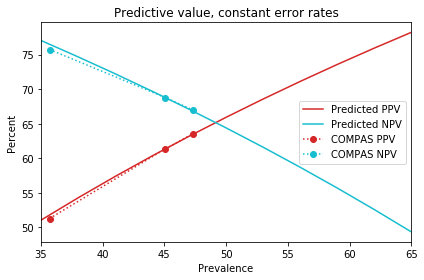

In [31]:
plot_cer_model(pred_pv)

actual_pv['ppv'].plot(marker='o', linestyle='dotted', color='C3',
                      label='COMPAS PPV')

actual_pv['npv'].plot(marker='o', linestyle='dotted', color='C9',
                      label='COMPAS NPV')

plt.legend();

The results agree with the CER model, which implies that COMPAS is sex-blind.  That is:

* The error rates (FPR and FNR) are nearly identical for male and female defendants.

* As a result, the predictive values (PPV and NPV) are substantially different.

Also, as we saw in a previous section, the calibration curves are substantially different:

* At every risk level, male subjects are more likely to be charged with another crime.

* If a male and female defendant have the same probability of recidivism, the female defendant is given a risk score 1-2 points higher, on average.

With respect to sex, COMPAS is fair by the criterion posed by the ProPublica article: it has the same error rates for groups with different prevalence.

As a result, it is entirely unfair by the criteria of the WaPo article, which argues:

> A risk score of seven for black defendants should mean the same thing as a score of seven for white defendants. Imagine if that were not so, and we systematically assigned whites higher risk scores than equally risky black defendants with the goal of mitigating ProPublica’s criticism. We would consider that a violation of the fundamental tenet of equal treatment.

With respect to male and female defendants, COMPAS violates this tenet.

So who's right?  We have two competing definitions of fairness, and it is literally impossible to satisfy them both.  Is it better to have equal error rates for all groups, as COMPAS does for men and women?  Or is it better to be calibrated, which implies equal predictive values?  Or, since we can't have both, should the test be "tempered", allowing both error rates and predictive values to depend on prevalence?

In the next notebook, I will propose a possible answer to these questions.

## ROC

**Note:** This section is a leftover for now.  Since the ProPublica article mentions AUC, I computes ROC curves for various groups.  I'll come back to this later.

From [How We Analyzed the COMPAS Recidivism Algorithm](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

> Both results are lower than what Northpointe describes as a threshold for reliability. “A rule of thumb according to several recent articles is that AUCs of .70 or above typically indicate satisfactory predictive accuracy, and measures between .60 and .70 suggest low to moderate predictive accuracy,” the company says in its study.

The following function loops through possible thresholds for the low and high risk groups.  For each threshold, it makes the confusion matrix and computes sensitivity and specificity.

In [32]:
thresholds = range(1, 10)
for threshold in thresholds:
    matrix = make_matrix(cp, male, threshold)
    t = sens_spec(matrix)
    print(threshold, t)

1 (90.73737740646567, 29.158512720156555)
2 (81.5474028332728, 45.00978473581213)
3 (73.1202324736651, 56.360078277886494)
4 (62.91318561569197, 67.57990867579909)
5 (53.25099891027969, 76.15786040443575)
6 (42.71703596077007, 82.87671232876713)
7 (32.11042499091899, 89.26940639269407)
8 (20.886305848165637, 93.50945857795173)
9 (9.44424264438794, 97.71689497716895)


When the threshold is low, almost everyone is in the high risk group; in that case:

* Sensitivity is high because most recidivists are in the high risk group, but 

* Specificity is low because most non-recidivists are *also* in the high risk group.

When the threshold is high, almost everyone is in the low risk group, and the metrics are the other way around:

* Sensitivity is low because most recidivists are in the low risk group, but

* Specificity is high because most non-recidivists are *also* in the low risk group.

One way to visualize these results is to plot sensitivity versus FPR (which is the complement of specificity) for a range of thresholds.  For historical reasons, the result is called a [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

The following function computes the ROC curve for a given subset of the data:

In [33]:
def make_roc(cp, group):

    thresholds = range(1, 10)
    roc = pd.DataFrame(index=thresholds, 
                   columns=['sens', 'spec'])

    for threshold in thresholds:
        matrix = make_matrix(cp, group, threshold)
        roc.loc[threshold] = sens_spec(matrix)
    
    roc['fpr'] = 100 - roc['spec']
    
    return roc

In [34]:
roc_male = make_roc(cp, male)
roc_male

,sens,spec,fpr
1,90.7374,29.1585,70.8415
2,81.5474,45.0098,54.9902
3,73.1202,56.3601,43.6399
4,62.9132,67.5799,32.4201
5,53.251,76.1579,23.8421
6,42.717,82.8767,17.1233
7,32.1104,89.2694,10.7306
8,20.8863,93.5095,6.49054
9,9.44424,97.7169,2.28311


In [35]:
roc_female = make_roc(cp, female)
roc_female

,sens,spec,fpr
1,89.3574,26.5329,73.4671
2,81.3253,44.5931,55.4069
3,71.4859,57.748,42.252
4,60.8434,67.893,32.107
5,48.7952,78.1494,21.8506
6,35.1406,86.7336,13.2664
7,23.494,91.8618,8.13824
8,15.261,95.4292,4.57079
9,7.22892,98.1048,1.89521


In [36]:
def plot_roc(roc):
    plt.plot(roc['fpr'], roc['sens'])

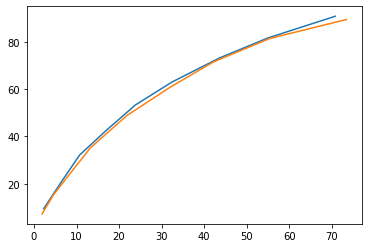

In [38]:
plot_roc(roc_male)
plot_roc(roc_female)

In [41]:
white = (cp.race=='Caucasian')
roc_white = make_roc(cp, white)
roc_white

,sens,spec,fpr
1,85.3002,36.2231,63.7769
2,73.6025,52.8898,47.1102
3,63.9752,64.9866,35.0134
4,52.2774,76.5457,23.4543
5,40.7867,85.2823,14.7177
6,29.2961,90.8602,9.13978
7,20.1863,94.5565,5.44355
8,11.6977,96.707,3.29301
9,4.65839,98.7231,1.27688


In [42]:
black = (cp.race=='African-American')
roc_black = make_roc(cp, black)
roc_black

,sens,spec,fpr
1,95.213,17.1031,82.8969
2,88.9532,32.3677,67.6323
3,81.3256,43.5655,56.4345
4,72.0147,55.1532,44.8468
5,62.7564,65.6825,34.3175
6,51.4466,75.0975,24.9025
7,38.9795,84.1783,15.8217
8,26.0915,90.5292,9.47075
9,11.9411,96.7131,3.28691


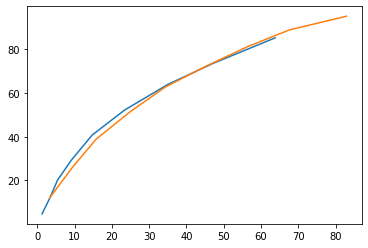

In [44]:
plot_roc(roc_white)
plot_roc(roc_black)